In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path
from sklearn.cluster import KMeans

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/bout")

In [3]:
from core import SITE_NAMES, FREQUENCY_COLOR_MAPPINGS
import clustering as clstr
import bout as bt
import plot as bt_plt
import activity.subsampling as ss
import activity.activity_assembly as actvt

from cli import get_file_paths
from calls import plot_call_features, compute_features, call_extraction

['/Users/adityakrishna/duty-cycle-investigation/daily_notebook', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python311.zip', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/lib-dynload', '', '/Users/adityakrishna/miniconda3/envs/dc-study/lib/python3.11/site-packages', '../src', '../src/bout', '../src/bout', '../src/bout', '../src/bout', '../src', '../src', '../src/activity', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/calls', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src/bout', '/Users/adityakrishna/duty-cycle-investigation/daily_notebook/../src']


In [4]:
FREQUENCY_COLOR_MAPPINGS = {
                    'LF' : 'cyan',
                    'HF' : 'yellow'
                        }

In [5]:
label_for_groups = {0: 'LF', 1: 'HF'}

In [6]:
PADDED_CALL_LENGTH = 0.06

def open_and_get_call_info(audio_file, kmean_welch, dets):
    fs = audio_file.samplerate
    call_signals = []
    welch_signals = []
    snrs = []
    peak_freqs = []
    classes = []
    nyquist = fs//2
    for index, row in dets.iterrows():
        call_dur = (row['end_time'] - row['start_time'])
        pad = 0.004
        start = row['start_time'] - call_dur - (3*pad)
        duration = (2 * call_dur) + (4*pad)
        end = row['end_time']
        audio_file.seek(int(fs*start))
        audio_seg = audio_file.read(int(fs*duration))
        
        low_freq_cutoff = row['low_freq']-5000
        high_freq_cutoff = min(nyquist-1, row['high_freq']+5000)
        band_limited_audio_seg = call_extraction.bandpass_audio_signal(audio_seg, fs, low_freq_cutoff, high_freq_cutoff)

        signal = band_limited_audio_seg.copy()
        signal[:int(fs*(call_dur+(2*pad)))] = 0

        noise = band_limited_audio_seg - signal

        snr_call_signal = signal[-int(fs*(call_dur+(2*pad))):]
        snr_noise_signal = noise[:int(fs*(call_dur+(2*pad)))]
        call_signals.append(snr_call_signal)

        snr = call_extraction.get_snr_from_band_limited_signal(snr_call_signal, snr_noise_signal)
        snrs.append(snr)

        welch_info = dict()
        welch_info['num_points'] = 100
        max_visible_frequency = 96000
        welch_info['max_freq_visible'] = max_visible_frequency
        welch_signal = compute_features.compute_welch_psd_of_call(snr_call_signal, fs, welch_info)
        welch_signals.append(welch_signal)

        peaks = np.where(welch_signal==max(welch_signal))[0][0]
        peak_freqs.append((96000/100)*peaks)
        
        welch_signal = (welch_signal).reshape(1, len(welch_signal))
        classes.append(kmean_welch.predict(welch_signal)[0])

    call_signals = np.array(call_signals, dtype='object')

    dets.reset_index(drop=True, inplace=True)
    dets['index'] = dets.index
    dets['file_name'] = pd.DatetimeIndex(pd.to_datetime(dets['input_file'], format='%Y%m%d_%H%M%S', exact=False)).strftime('%Y%m%d_%H%M%S.WAV')
    dets['sampling_rate'] = len(dets) * [fs]
    dets['SNR'] = snrs
    dets['KMEANS_CLASSES'] = pd.Series(classes).map(label_for_groups)
    dets['peak_frequency'] = peak_freqs

    return call_signals, dets

In [7]:
def plot_colored_dets_over_audio_seg(audio_features, spec_features, plot_dets):
    """
    Function to plot the spectrogram of a provided audio segment with overlayed detections
    """

    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.title(f"BatDetect2 detections on {audio_features['file_path'].name}", fontsize=22)
    plt.rcParams.update({'font.size': 24})
    plt.specgram(audio_seg, NFFT=spec_features['NFFT'], cmap=spec_features['cmap'], vmin=spec_features['vmin'])

    yellow_patch = patches.Patch(facecolor='yellow', edgecolor='k', label='Detections')

    legend_patches = [yellow_patch]
    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQUENCY_COLOR_MAPPINGS[row['KMEANS_CLASSES']], facecolor='none', alpha=0.8)
        
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), labels=np.round(np.linspace(start, start+duration, 11, dtype='float'), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.gcf().autofmt_xdate()
    plt.legend(handles=legend_patches, fontsize=20, ncol=int(len(legend_patches)**0.5), loc='upper right')

    plt.tight_layout()
    plt.show()

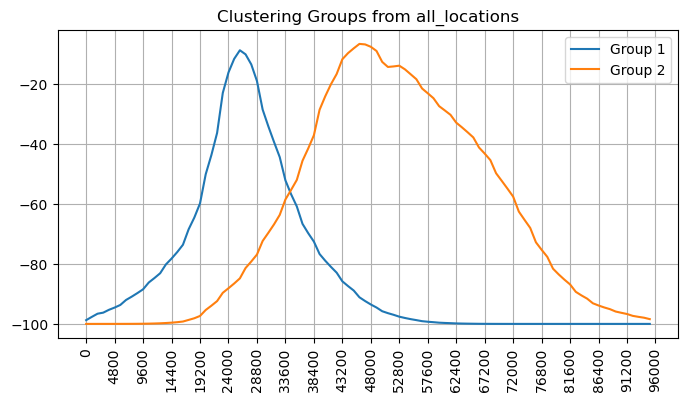

In [8]:
welch_key = 'all_locations'

output_dir = Path(f'../data/generated_welch/{welch_key}')
if not(output_dir.is_dir()):
    output_dir.mkdir(parents=True)
output_file_type = 'top1_inbouts_welch_signals'

welch_data = pd.read_csv(output_dir / f'2022_{welch_key}_{output_file_type}.csv', index_col=0, low_memory=False)

k = 2
kmean_welch = KMeans(n_clusters=k, n_init=10, random_state=1).fit(welch_data.values)
plt.figure(figsize=(8, 4))
plt.title(f'Clustering Groups from {welch_key}')
for i in range(k):
    plt.plot(kmean_welch.cluster_centers_[i], label=f'Group {i+1}')
plt.xticks(np.linspace(0, welch_data.shape[1], 21), np.linspace(0, 96000, 21, dtype=int), rotation=90)
plt.grid(which='both')
plt.legend()
plt.show()

In [9]:
site_key = 'Foliage'

fig_details = dict()
fig_details['site_name'] = SITE_NAMES[site_key]
print(f'Looking at {fig_details["site_name"]}')
files_from_loc = sorted(list(Path(f'../data/audiomoth_recordings/').glob(pattern=f'*/{site_key}/*.WAV')))

Looking at Foliage


In [10]:
files_from_loc[7]

PosixPath('../data/audiomoth_recordings/recover-20220804/Foliage/20220802_060000.WAV')

In [11]:
file_path = files_from_loc[7]
filename = file_path.name

audio_file = sf.SoundFile(file_path)
fs = audio_file.samplerate
start = 130
duration = 20
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
vmin = 20*np.log10(np.max(audio_seg)) - 40 # hide anything below -rm_dB dB

data_params = dict()
data_params['site_tag'] = site_key
data_params['type_tag'] = ''
data_params['cur_dc_tag'] = '1800of1800'

file_paths = get_file_paths(data_params)

audio_features = dict()
audio_features['file_path'] = file_path
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['vmin'] = vmin
spec_features['NFFT'] = 512
spec_features['cmap'] = 'jet'

In [12]:
csv_path = Path(f'../data/raw/{site_key}/bd2__{site_key}_{filename.split(".")[0]}.csv')
batdetect2_predictions_no_dutycycle = actvt.assemble_single_bd2_output(csv_path, data_params)
plot_dets_no_dutycycle = batdetect2_predictions_no_dutycycle.loc[np.logical_and(batdetect2_predictions_no_dutycycle['start_time'] > start, batdetect2_predictions_no_dutycycle['end_time'] < (start+duration))]

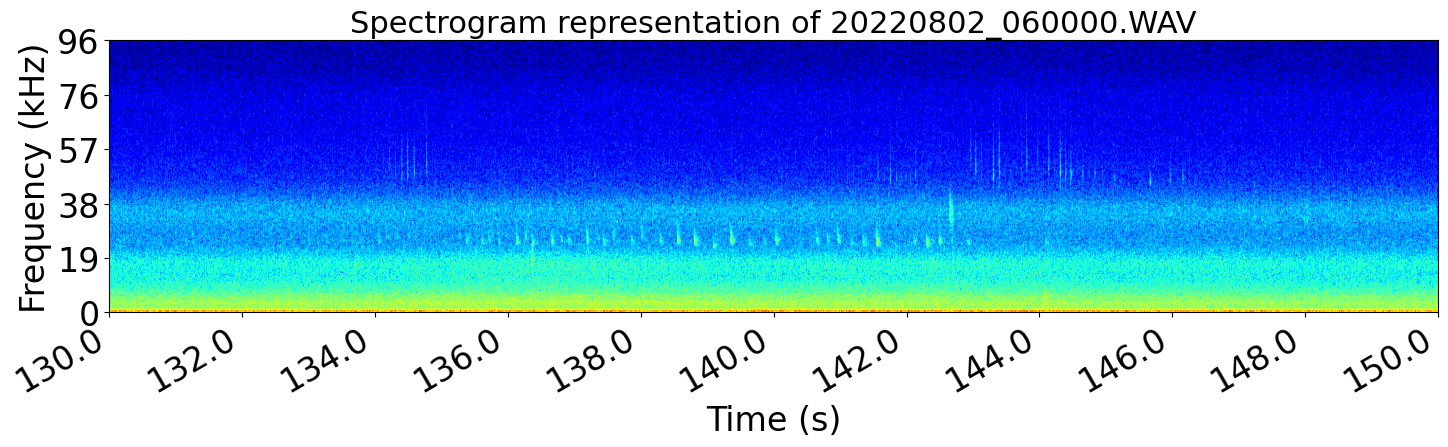

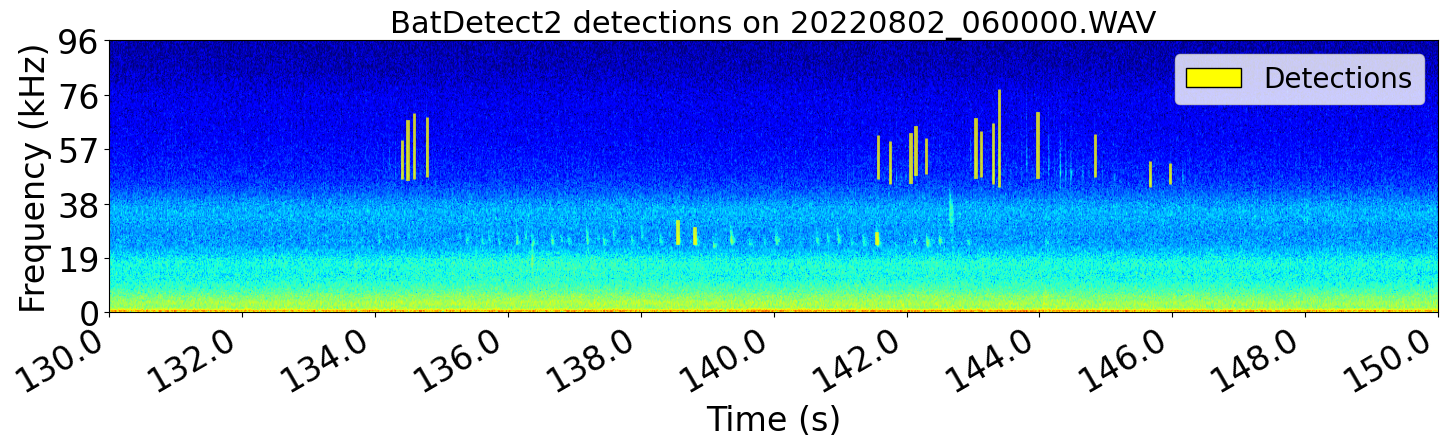

In [13]:
bt_plt.plot_audio_seg(audio_features, spec_features)
bt_plt.plot_dets_over_audio_seg(audio_features, spec_features, plot_dets_no_dutycycle)

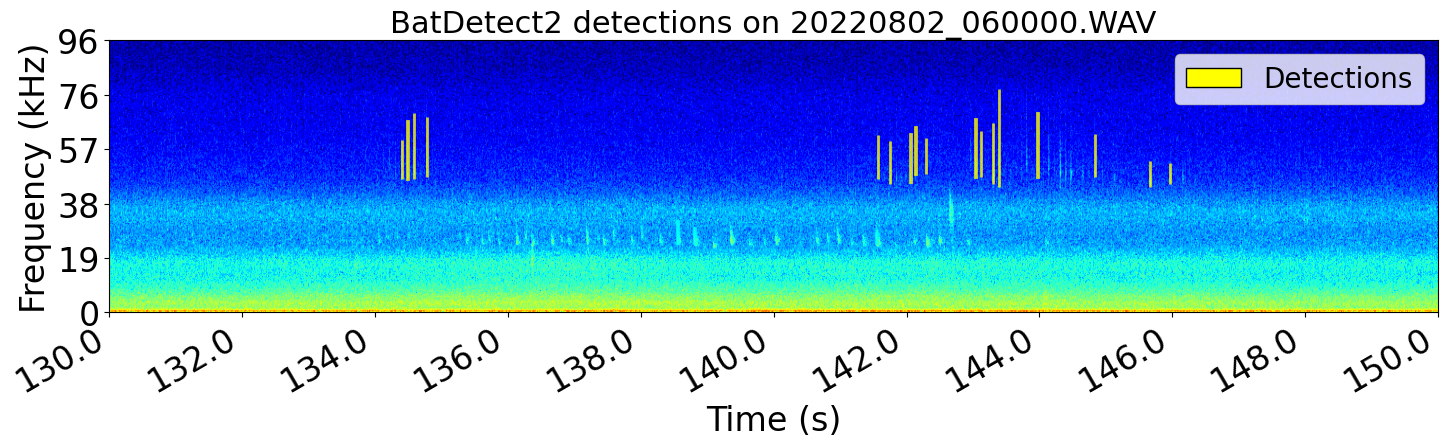

In [14]:
call_signals, dets = open_and_get_call_info(audio_file, kmean_welch, plot_dets_no_dutycycle.copy())
plot_colored_dets_over_audio_seg(audio_features, spec_features, dets)